In [1]:
import os

# import sys
# sys.path.append(os.path.abspath("/app/utils"))

from utils.helper import *
from utils.dataProcess import *
from datetime import datetime,timedelta
import open3d as o3d
from scipy.io import savemat
from concurrent.futures import ProcessPoolExecutor
import cv2
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import concurrent.futures
from utils.helper import *
import gc
import time
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
#defining the folder to strore the for every session 
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
processedDataFolder_name = f"./processedData/{timestamp}/"
depVis = processedDataFolder_name + "visualization/depth/"
radVis = processedDataFolder_name + "visualization/radar/"
merRadDepVis = processedDataFolder_name + "visualization/RadarDepth/"
merRadDepVisdownSample = processedDataFolder_name + "visualization/downSampledRadarDepth/"

In [ ]:

# Check if the folder exists, if not, create it
if not os.path.exists(processedDataFolder_name):
    os.makedirs(processedDataFolder_name)
    os.makedirs(depVis)
    os.makedirs(radVis)
    os.makedirs(merRadDepVis)
    os.makedirs(merRadDepVisdownSample)
    print(f"Folder '{processedDataFolder_name}' created.")
else:
    print(f"Folder '{processedDataFolder_name}' already exists.")

Folder './processedData/2025-03-12_11-54-18/' created.


In [4]:

def density_based_downsampling(pcd, target_num_points,voxelSize):
    """
    Perform density-based downsampling using voxel grid filtering.

    Args:
        pcd (open3d.geometry.PointCloud): Input point cloud.
        voxel_size (float): Size of the voxel grid. Smaller size means higher resolution.
    
    Returns:
        downsampled_pcd (open3d.geometry.PointCloud): Downsampled point cloud.
    """
     # Step 1: Estimate the diagonal length of the bounding box for the point cloud
    bbox_min = pcd.get_min_bound()
    bbox_max = pcd.get_max_bound()
    diagonal_length = np.linalg.norm(bbox_max - bbox_min)  # Calculate the length of the diagonal

    # Step 2: Calculate the downsampling ratio and estimate a scalar voxel size
    num_original_points = np.asarray(pcd.points).shape[0]
    ratio = num_original_points / target_num_points
    voxel_size = diagonal_length / (ratio ** (1/3)) 
    print("Voxel size:",  voxel_size)
    # Step 2: Perform voxel grid downsampling
    downsampled_pcd = pcd.voxel_down_sample(voxel_size=voxel_size*0.001)
    
    # Step 3: Check if we have more points than required (voxel grid downsampling might give slightly more)
    num_downsampled_points = len(downsampled_pcd.points)
    
    if num_downsampled_points > target_num_points:
        # Randomly select 'target_num_points' from the downsampled point cloud
        indices = np.random.choice(num_downsampled_points, target_num_points, replace=False)
        downsampled_pcd = downsampled_pcd.select_by_index(indices)
    return downsampled_pcd


In [5]:
def pointcloud_openradar(file_name):
    print(f"{file_name} initialized")
    info_dict = get_info(file_name)
    # print_info(info_dict)
    run_data_read_only_sensor(info_dict)
    bin_filename = './datasets/radar_data/only_sensor_' + info_dict['filename'][0]
    # make fixedPoint True get fixed number of points
    pcd_data, time , dopplerResult, rangeResult, rangeAzimuthzResult,rawHeatmap = generate_pcd_time(bin_filename, info_dict,fixedPoint=True,fixedPointVal=1000)
    # print(pcd_data.shape)
    return pcd_data, time, dopplerResult, rangeResult, rangeAzimuthzResult,rawHeatmap


In [6]:
def process_bin_file(file, radarFilePath):
    """Process a single bin file and generate a CSV."""
    binFileFrame = []
    binFilesnr = []
    binFilerange = []
    binFileangle = []
    binFilepower = []
    binFiledoppler = []
    binFilePath = radarFilePath + file
    gen, timestamps, dopplerResult, rangeResult, rangeAzimuthzResult,heatmapResult= pointcloud_openradar(file_name=binFilePath)

    for pointcloud in gen:
        binFileFrame.append(pointcloud[:, :3])  # Sliced first 3 as x, y, z
        binFiledoppler.append(pointcloud[:,2])
        binFilesnr.append(pointcloud[:,3])
        binFilerange.append(pointcloud[:,4])
        binFileangle.append(pointcloud[:,5])
        binFilepower.append(pointcloud[:,6])

    # Create a DataFrame for this bin file
    df = pd.DataFrame()
    df["datetime"] = timestamps[:gen.shape[0]]
    df["radarPCD"] = binFileFrame
    df["doppler"] = binFiledoppler
    df["snr"] = binFilesnr
    df["range"] = binFilerange
    df["angle"] = binFileangle
    df["power"] = binFilepower
    df['dopplerResult'] = dopplerResult
    df['rangeResult'] = rangeResult
    df['rangeAzimuthzResult'] = rangeAzimuthzResult
    df['heatmapResult'] = heatmapResult
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H_%M_%S.%f')

    # Save CSV
    saveCsv = radarFilePath + "csv_file/" + file.split(".")[0] + ".csv"
    radarCSVDir = radarFilePath + "csv_file/"
    if not os.path.exists(radarCSVDir):
        os.makedirs(radarCSVDir)
    
    # df.to_csv(saveCsv, index=False)
    return df  # Returning DataFrame for appending later if needed


In [7]:
datasetsFolderPath = './datasets/'
radarFilePath = os.path.join(datasetsFolderPath,"radar_data/")
depthFilePath = os.path.join(datasetsFolderPath,"depth_data/")
filteredBinFile = [f for f in os.listdir(radarFilePath) if os.path.isfile(os.path.join(radarFilePath, f)) and f.endswith('.bin') and not f.startswith('only_sensor')]
filteredPKLFile = [f for f in os.listdir(depthFilePath) if os.path.isfile(os.path.join(depthFilePath, f)) and f.endswith('.pkl') and not f.startswith('only_sensor')]

if len(filteredBinFile) != len(filteredPKLFile):
    print("List of CSV and BIN file is mismatched")
print("List of CSV and BIN file matched")

List of CSV and BIN file matched


In [8]:
filteredBinFile

['drone_2025-01-29_12_41_45_test.bin']

In [9]:
total_framePCD = []
total_frameRadarDF = pd.DataFrame(columns=["datetime","radarPCD"])
with concurrent.futures.ProcessPoolExecutor(max_workers= 5) as executor:
    results = list(executor.map(process_bin_file, filteredBinFile, [radarFilePath] * len(filteredBinFile)))

for df in results:
    total_frameRadarDF = pd.concat([total_frameRadarDF, df], ignore_index=True)#total_frameRadarDF.append(df, ignore_index=True)

print("BIN file Processing completed.")


./datasets/radar_data/drone_2025-01-29_12_41_45_test.bin initialized


/home/tirtha/mmSLAM/OpenRadar/mmwave/tracking/gtrack_module.py:157: RuntimeWarning: overflow encountered in cast
  inst.bestScore[n] = sys.float_info.max
/home/tirtha/mmSLAM/OpenRadar/mmwave/tracking/gtrack_unit.py:350: RuntimeWarning: divide by zero encountered in scalar divide
  rvError = np.float32((inst.H_s[2] - um[2]) / um[2])


BIN file Processing completed.


In [10]:
#camera part
total_frameDepth = pd.DataFrame(columns=["datetime","depthPCD"])
totalDepthFrame = []
totalDepthFrameTimestamps = []
with concurrent.futures.ProcessPoolExecutor(max_workers=5) as file_executor:
        results = list(file_executor.map(load_and_process_file, filteredPKLFile))


Frame initialized: 0 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 1 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 2 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 3 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 4 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 5 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 6 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 7 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 8 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 9 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 10 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 11 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 12 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 13 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 14 drone_2025-01-29_12_41_45_test_depth.pkl
Frame initialized: 15 drone_2025-01-29_12_41_45_test_depth.pkl
Fr

In [11]:
for fileDepthFrame, fileDepthFrameTimestamps in results:
    print("Time Stamp: ",fileDepthFrameTimestamps)
    totalDepthFrame += fileDepthFrame
    totalDepthFrameTimestamps += fileDepthFrameTimestamps

print("Processing completed.")

Time Stamp:  ['2025-01-29 12:41:46.829741', '2025-01-29 12:41:46.927161', '2025-01-29 12:41:47.025932', '2025-01-29 12:41:47.080467', '2025-01-29 12:41:47.119968', '2025-01-29 12:41:47.168573', '2025-01-29 12:41:47.214389', '2025-01-29 12:41:47.262676', '2025-01-29 12:41:47.304238', '2025-01-29 12:41:47.353630', '2025-01-29 12:41:47.400579', '2025-01-29 12:41:47.445595', '2025-01-29 12:41:47.488432', '2025-01-29 12:41:47.534417', '2025-01-29 12:41:47.595027', '2025-01-29 12:41:47.644495', '2025-01-29 12:41:47.688930', '2025-01-29 12:41:47.733684', '2025-01-29 12:41:47.780611', '2025-01-29 12:41:47.821989', '2025-01-29 12:41:47.867166', '2025-01-29 12:41:47.904549', '2025-01-29 12:41:47.945640', '2025-01-29 12:41:47.986439', '2025-01-29 12:41:48.025351', '2025-01-29 12:41:48.067510', '2025-01-29 12:41:48.104099', '2025-01-29 12:41:48.152540', '2025-01-29 12:41:48.208631', '2025-01-29 12:41:48.245368', '2025-01-29 12:41:48.286645', '2025-01-29 12:41:48.328274', '2025-01-29 12:41:48.37526

In [12]:
total_frameDepth["depthPCD"] = totalDepthFrame
total_frameDepth["datetime"] = totalDepthFrameTimestamps
del totalDepthFrame 
total_frameDepth['datetime'] = pd.to_datetime(total_frameDepth['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
total_frameDepth.dropna()
total_frameDepth.to_csv(processedDataFolder_name + "total_frameDepth.csv",index=False)
del totalDepthFrameTimestamps 

In [13]:
print("total_frameStackedRadar.shape: ",np.stack(total_frameRadarDF["radarPCD"]).shape)
# total_frameStackedDepth = np.stack(total_frameDepth["depthPCD"])
print("total_frameStackedDepth.shape: ",np.stack(total_frameDepth["depthPCD"]).shape)

# mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('600ms'), direction='nearest')
# print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)



total_frameStackedRadar.shape:  (500, 1000, 3)
total_frameStackedDepth.shape:  (651, 307200, 3)


In [14]:
total_frameDepth.head()

,datetime,depthPCD
0,2025-01-29 12:41:46.829741,"[[-1.0291497, 1.9380001, -0.74916923], [-1.025..."
1,2025-01-29 12:41:46.927161,"[[-1.0227773, 1.9260001, -0.74453044], [-1.019..."
2,2025-01-29 12:41:47.025932,"[[-1.019591, 1.9200001, -0.742211], [-1.016429..."
3,2025-01-29 12:41:47.080467,"[[-1.0291497, 1.9380001, -0.74916923], [-1.025..."
4,2025-01-29 12:41:47.119968,"[[-1.0355221, 1.95, -0.753808], [-1.0323112, 1..."


In [15]:

total_frameRadarDF = total_frameRadarDF.sort_values(by='datetime', ascending=True)
total_frameDepth = total_frameDepth.sort_values(by='datetime', ascending=True)
    

In [16]:
total_frameRadarDF.head()

,datetime,radarPCD,doppler,snr,range,angle,power,dopplerResult,rangeResult,rangeAzimuthzResult,heatmapResult
0,2025-01-29 12:41:45.000,"[[-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0], [-0.0, 0....","[0.0, 0.0, 0.0, -0.04955362, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 2.8753157, 0.0, 0.0, 0.0, 3.73...","[0.0, 0.0, 0.0, 2.1050477, 0.0, 0.0, 0.0, 4.94...","[0.0, 0.0, 0.0, 0.7330383, 0.0, 0.0, 0.0, 1.74...","[0.0, 0.0, 0.0, 4046887000000000.0, 0.0, 0.0, ...","[[0.007291956152239405, 0.0019322811505037448,...","[[[(148114.72893772926-243043.37912087888j), (...","[[1.5895258448310339, 1.5895258448310339, 9.96...","[[32.28985169659008, 30.998860141321092, 30.87..."
1,2025-01-29 12:41:45.200,"[[-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0], [-0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04955362, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.6645806, 3.26...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0191274, 9.62...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0646509, 1.97...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.965976e+16, 1...","[[0.004117286427607061, 0.0010802682709493423,...","[[[(-390473.5549450554-348793.2637362629j), (1...","[[3.6945735852829436, 3.2649720055988802, 3.69...","[[30.068001520372242, 29.67350264351542, 29.89..."
2,2025-01-29 12:41:45.400,"[[-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0], [-2.28802...","[0.0, 0.0, 0.04955362, 0.0, 0.0, 0.0, 0.0, 1.8...","[0.0, 0.0, 2.5668283, 0.0, 0.0, 0.0, 0.0, 2.82...","[0.0, 0.0, 2.4057689, 0.0, 0.0, 0.0, 0.0, 3.17...","[0.0, 0.0, 1.2566371, 0.0, 0.0, 0.0, 0.0, 0.29...","[0.0, 0.0, 3427076000000000.0, 0.0, 0.0, 0.0, ...","[[0.13188386494337712, 0.08105328021871523, 0....","[[[(517530.66483516525-35298.95787545852j), (-...","[[0.5584820535892822, 0.5584820535892822, 1.58...","[[29.194782667827372, 28.94060140357535, 29.29..."
3,2025-01-29 12:41:45.600,"[[-0.0, 0.0, 0.0], [-0.44997412, 1.5692463, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, -0.04955362, 0.04955...","[0.0, 2.633287, 0.0, 0.0, 0.0, 2.6452742, 2.65...","[0.0, 1.632486, 0.0, 0.0, 0.0, 6.315143, 2.019...","[0.0, 0.27925268, 0.0, 0.0, 0.0, 0.6457718, 1....","[0.0, 515897580000000.0, 0.0, 0.0, 0.0, 243501...","[[0.040995841623775876, 0.026873007433347095, ...","[[[(324688.4706959706-25438.25824175775j), (-2...","[[1.5895258448310339, 1.5895258448310339, 3.17...","[[29.15991804223609, 28.976156193642968, 28.96..."
4,2025-01-29 12:41:45.800,"[[-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0], [-0.0, 0....","[0.0, 0.0, 0.0, -0.04955362, -0.04955362, 0.0,...","[0.0, 0.0, 0.0, 2.7805786, 3.1315653, 0.0, 0.0...","[0.0, 0.0, 0.0, 3.8664143, 2.0620875, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.4886922, 1.012291, 0.0, 0.0,...","[0.0, 0.0, 0.0, 351449600000000.0, 73950690000...","[[0.0390822672932543, 0.01784899498316063, 0.0...","[[[(319681.1611721609-34831.86996337026j), (-3...","[[3.1790516896620677, 1.5895258448310339, 3.17...","[[29.838117563582127, 29.711185900448204, 29.1..."


In [17]:
#######################################################################
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('200ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth =mergerdPcdDepth.dropna(subset=['depthPCD'])
print("200ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

mergerdPcdDepth.shape:  (500, 12)
200ms - mergerdPcdDepth after dropna.shape:  (160, 12)


In [ ]:
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('400ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth =mergerdPcdDepth.dropna(subset=['depthPCD'])
print("400ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('600ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth =mergerdPcdDepth.dropna(subset=['depthPCD'])
print("600ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:

mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('800ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth = mergerdPcdDepth.dropna(subset=['depthPCD'])
print("800ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('1000ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth = mergerdPcdDepth.dropna(subset=['depthPCD'])
print("1000ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('3000ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth = mergerdPcdDepth.dropna(subset=['depthPCD'])
print("3000ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [18]:
mergerdPcdDepth.to_csv(processedDataFolder_name + "/mergedRadarDepth.dat", sep = ' ', index=False)
print("mergedRadarDepth.dat Exported")

mergerdPcdDepth.to_csv(processedDataFolder_name + "/mergedRadarDepth.csv", index=False)

mergerdPcdDepth.to_pickle(processedDataFolder_name + "/mergedRadarDepth.pkl")
print("mergedRadarDepth.pkl Exported")

total_frameRadarDF.to_pickle(processedDataFolder_name + "/total_frameRadarDF.pkl")
print("total_frameRadarDF.pkl Exported")

total_frameDepth.to_pickle(processedDataFolder_name + "/total_frameDepth.pkl")
print("total_frameDepth.pkl Exported")


print(f"Data Processing Done and data exporte to file {processedDataFolder_name}")

mergedRadarDepth.dat Exported
mergedRadarDepth.pkl Exported
total_frameRadarDF.pkl Exported
total_frameDepth.pkl Exported
Data Processing Done and data exporte to file ./processedData/2025-03-12_11-54-18/


In [ ]:
#dummy merge produce
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('5ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth =mergerdPcdDepth.dropna(subset=['depthPCD'])
print("200ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:
# mergerdPcdDepth["radarPCD"][10][:,0]

### Visualization

In [ ]:

for index, row in tqdm(mergerdPcdDepth.iterrows(), total=len(mergerdPcdDepth), desc="Processing frames"):
    sns.set(style="whitegrid")
    fig1 = plt.figure(figsize=(12,7))
    ax1 = fig1.add_subplot(111,projection='3d')
    img1 = ax1.scatter(mergerdPcdDepth["radarPCD"][index][:,0], mergerdPcdDepth["radarPCD"][index][:,1], mergerdPcdDepth["radarPCD"][index][:,2], cmap="jet",marker='o')
    fig1.colorbar(img1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    # ax1.set_xlim(-10, 10)
    # ax1.set_ylim(-10, 10)
    # ax1.set_zlim(-10, 10)
    frameTime = mergerdPcdDepth["datetime"][index]
    ax1.set_title(f"Radar Point Cloud Frame {index} Time {frameTime}")
    plt.savefig(radVis + "radar_"+ str(index)+".png")
    # plt.show()
    plt.close()


In [ ]:

for index, row in tqdm(mergerdPcdDepth.iterrows(), total=len(mergerdPcdDepth), desc="Processing frames"):
    sns.set(style="whitegrid")
    fig2 = plt.figure(figsize=(12,7))
    ax2 = fig2.add_subplot(111,projection='3d')
    img2 = ax2.scatter(mergerdPcdDepth["depthPCD"][index][:,0], mergerdPcdDepth["depthPCD"][index][:,1],mergerdPcdDepth["depthPCD"][index][:,2], cmap="viridis",marker='o')
    fig2.colorbar(img2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    # ax2.set_xlim(-10, 10)
    # ax2.set_ylim(-10, 10)
    # ax2.set_zlim(-10, 10)
    frameTime = mergerdPcdDepth["datetime"][index]
    ax2.set_title(f"Depth Point Cloud Frame {index} Time {frameTime}")
    plt.savefig(depVis + "depthFrame_"+ str(index)+".png")
    # plt.show()
    plt.close()

In [ ]:
for index, row in tqdm(mergerdPcdDepth.iterrows(), total=len(mergerdPcdDepth), desc="Processing frames"):
    # frameIDX = np.random.randint(0, mergerdPcdDepth.shape[0])
    frameIDX = index
    distancesRadar = np.linalg.norm(mergerdPcdDepth["radarPCD"][frameIDX], axis=1)
    normalized_distances = (distancesRadar - distancesRadar.min()) / (distancesRadar.max() - distancesRadar.min())
    sns.set(style="whitegrid")
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121,projection='3d')
    distancesRadar = np.linalg.norm(mergerdPcdDepth["radarPCD"][frameIDX], axis=1)
    normalized_distancesRadar = (distancesRadar - distancesRadar.min()) / (distancesRadar.max() - distancesRadar.min())
    img1 = ax1.scatter(mergerdPcdDepth["radarPCD"][frameIDX][:, 0], mergerdPcdDepth["radarPCD"][frameIDX][:, 1], mergerdPcdDepth["radarPCD"][frameIDX][:, 2], c=normalized_distancesRadar,cmap = 'viridis', marker='o')
    fig.colorbar(img1)
    ax1.set_title('Radar PCD')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    ax2 = fig.add_subplot(122,projection='3d')
    distancesDepth = np.linalg.norm(mergerdPcdDepth["depthPCD"][frameIDX], axis=1)
    normalized_distancesDepth = (distancesDepth - distancesDepth.min()) / (distancesDepth.max() - distancesDepth.min())
    img2 = ax2.scatter(mergerdPcdDepth["depthPCD"][frameIDX][:, 0], mergerdPcdDepth["depthPCD"][frameIDX][:, 1], mergerdPcdDepth["depthPCD"][frameIDX][:, 2], c=normalized_distancesDepth, cmap = 'viridis',marker='o')
    fig.colorbar(img2)
    ax2.set_title('Depth Camera PCD')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    plt.tight_layout()
    plt.savefig(merRadDepVis + f"radarDepth_{str(frameIDX)}.png")
    # plt.show()
    plt.close()

In [7]:
if True:
    processedDataFolder_name = "./processedData/2025-03-18_11-11-03/"
    mergedRadarDepth = pd.read_pickle(processedDataFolder_name + "mergedRadarDepth.pkl")

In [8]:
mergedRadarDepth.head(2)

,datetime,radarPCD,doppler,snr,range,angle,power,dopplerResult,rangeResult,rangeAzimuthzResult,heatmapResult,depthPCD
0,2024-10-02 20:20:33.000,"[[-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0], [-0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.06778126324202181, 0.04590564665427576, 0....","[[[(-152807.67765567824-186736.73076923098j), ...","[[10.396358228354329, 1.5036055288942212, 2.23...","[[30.83553415246314, 31.88168538318067, 31.556...","[[-2.52455, 4.754, -1.8377454], [-2.5167217, 4..."
1,2024-10-02 20:20:33.200,"[[-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0], [-0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.15275323721842382, 0.06435991854002387, 0....","[[[(-330181.1831501834+18851.366300365888j), (...","[[1.5895258448310339, 1.5036055288942212, 1.58...","[[31.419097360438627, 30.702228466292148, 30.9...","[[-2.52455, 4.754, -1.8377454], [-2.5167217, 4..."


In [10]:
mergedRadarDepth.shape

(3182, 12)

Range Doppler Azimuth Plot


In [9]:
datasetFolder = "./datasetsFull/image_data/"
image_data = []
for subdir, _, files in os.walk(datasetFolder):
    for file in files:
        if file.endswith(".jpg"):  
            file_path = os.path.join(subdir, file)
            renamedFile = file[:-4]
            renamedFiletimestamp = datetime.strptime(renamedFile, "%Y-%m-%d_%H_%M_%S_%f")
            renamedFileFormattedTime = renamedFiletimestamp.strftime("%Y-%m-%d %H:%M:%S.%f") + ".jpg"
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            date_str, time_hr,time_min,time_sec, microseconds = file[:-4].split("_")
            datetime_str = f"{date_str} {time_hr}:{time_min}:{time_sec}.{microseconds}"
            timestamp = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S.%f")
            formatted_timestamp = timestamp.strftime("%Y-%m-%d %H:%M:%S.%f")
            image_data.append([formatted_timestamp, image, renamedFileFormattedTime, file_path])

rgbCsvDF = pd.DataFrame(image_data, columns=[ "datetime", "rgbImage","rgbFilename", "rgbFilepath"])
rgbCsvDF["datetime"] = pd.to_datetime(rgbCsvDF["datetime"], format="%Y-%m-%d %H:%M:%S.%f")
rgbCsvPath = os.path.join(processedDataFolder_name, "rgbImage.csv")
rgbCsvDF.to_csv(rgbCsvPath, index=False)
rgbCsvDF.to_pickle(processedDataFolder_name + "rgbImage.pkl")
print(f"pkl file saved at: {rgbCsvPath}")



pkl file saved at: ./processedData/2025-03-18_11-11-03/rgbImage.csv


In [23]:
rgbCsvDF = rgbCsvDF.sort_values(by='datetime', ascending=True)
mergedRadarDepth = mergedRadarDepth.sort_values(by='datetime', ascending=True)

mergedRadarDepthRgb = pd.merge_asof(mergedRadarDepth, rgbCsvDF, on='datetime',tolerance=pd.Timedelta('100ms'), direction='nearest')#change ms
print("mergedRadarDepthRgb.shape: ",mergedRadarDepthRgb.shape)
mergedRadarDepthRgb =mergedRadarDepthRgb.dropna(subset=['rgbFilename'])
print("100ms - mergedRadarDepthRgb after dropna.shape: ",mergedRadarDepthRgb.shape)

mergedRadarDepthRgb.to_csv(processedDataFolder_name + "mergedRadarDepthRgb.csv", index=False)
mergedRadarDepthRgb.reset_index(drop=True).to_pickle(processedDataFolder_name + "mergedRadarDepthRgb.pkl")
print("mergedRadarDepthRgb.pkl Exported")

mergedRadarDepthRgb.shape:  (3182, 15)
100ms - mergedRadarDepthRgb after dropna.shape:  (1065, 15)
mergedRadarDepthRgb.pkl Exported


In [26]:
mergedRadarDepthRgb =  pd.read_pickle(processedDataFolder_name + "mergedRadarDepthRgb.pkl")

In [27]:
mergedRadarDepthRgb.head(2)

,datetime,radarPCD,doppler,snr,range,angle,power,dopplerResult,rangeResult,rangeAzimuthzResult,heatmapResult,depthPCD,rgbImage,rgbFilename,rgbFilepath
0,2024-10-02 20:20:34.600,"[[-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0], [-0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.035625794865224165, 0.008788970562096422, ...","[[[(689007.8901098892+1391128.2271062266j), (4...","[[0.6014422115576885, 0.6014422115576885, 1.50...","[[31.953999297962877, 31.95571001748119, 32.10...","[[-2.52455, 4.754, -1.8377454], [-2.5167217, 4...","[[[1, 2, 0], [1, 2, 0], [1, 2, 0], [1, 2, 0], ...",2024-10-02 20:20:34.687044.jpg,./datasetsFull/image_data/2024-10-02_20_20_33/...
1,2024-10-02 20:20:34.800,"[[-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0], [-0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.04029902170702497, 0.014095407464452403, 0...","[[[(1072266.4780219784+1170866.6300366297j), (...","[[1.5036055288942212, 1.5036055288942212, 1.50...","[[32.778026509726956, 34.13598755145461, 34.13...","[[-2.585088, 4.868, -1.8818141], [-2.5770721, ...","[[[19, 29, 13], [23, 33, 17], [23, 34, 18], [2...",2024-10-02 20:20:34.812791.jpg,./datasetsFull/image_data/2024-10-02_20_20_33/...


In [29]:
mergedRadarDepthRgb['rangeResult'][0].shape

(546, 4, 256)

In [39]:
mergedRadarDepthRgb['rangeResult'][0].sum(axis=(0,1)).shape

(256,)

In [76]:
# Data sampling configuration
c = 3e8 # Speed of light (m/s)
sample_rate = 4400 # Rate at which the radar samples from ADC (ksps - kilosamples per second)
freq_slope = 77 # Frequency slope of the chirp (MHz/us)
adc_samples = 256 # Number of samples from a single chirp
# Calculating bandwidth of the chirp, accounting for unit conversion
chirp_bandwidth = (freq_slope * 1e12 * adc_samples) / (sample_rate * 1e3)
print(f' chirp_bandwidth: {chirp_bandwidth} ')

# Using our derived equation for range resolution
range_res = c / (2 * chirp_bandwidth)
print(f'Range Resolution: {range_res} [meters]')
ranges = np.arange(adc_samples) * range_res

 chirp_bandwidth: 4480000000.0 
Range Resolution: 0.033482142857142856 [meters]


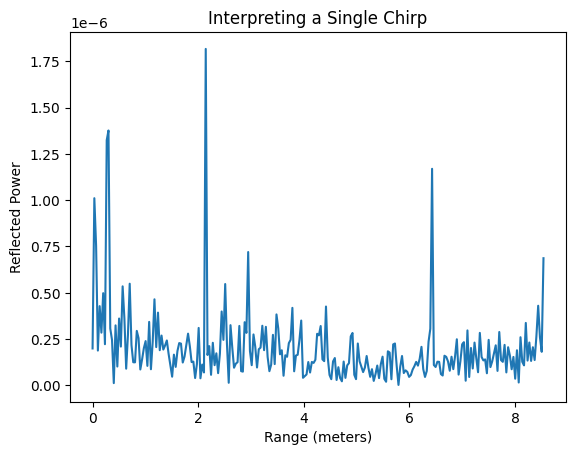

In [77]:
plt.plot(ranges,np.abs(mergedRadarDepthRgb['rangeResult'][0].sum(axis=(0,1))))
plt.xlabel('Range (meters)')
plt.ylabel('Reflected Power')
plt.title('Interpreting a Single Chirp')
plt.show()

In [84]:
# mergedRadarDepthRgb['heatmapResult'][0][0]

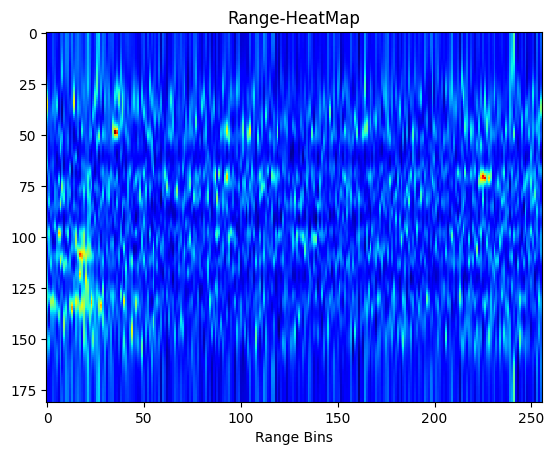

In [79]:
plt.imshow(mergedRadarDepthRgb['heatmapResult'][0], aspect='auto', cmap='jet', interpolation='nearest')
plt.xlabel('Range Bins')
plt.title('Range-HeatMap')
plt.show()

In [85]:
matrix = mergedRadarDepthRgb['heatmapResult'][0]


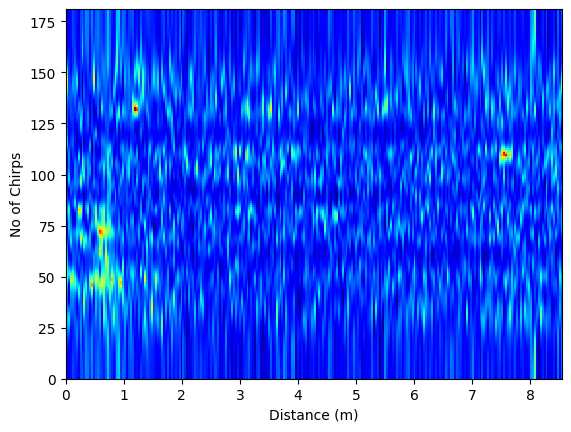

In [86]:
plt.imshow(mergedRadarDepthRgb['heatmapResult'][0], extent=[ranges[0], ranges[-1], 0, matrix.shape[0]],aspect='auto', cmap='jet', interpolation='nearest')
plt.xlabel('Distance (m)')
plt.ylabel('No of Chirps')
plt.show()

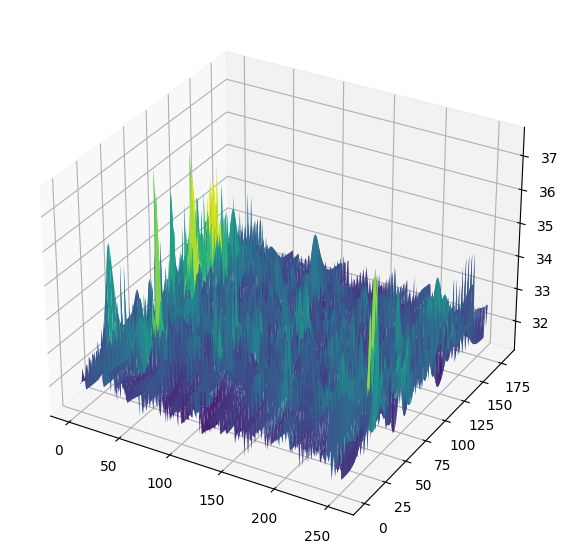

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
ax.plot_surface(X, Y, matrix, cmap='viridis')
plt.show()

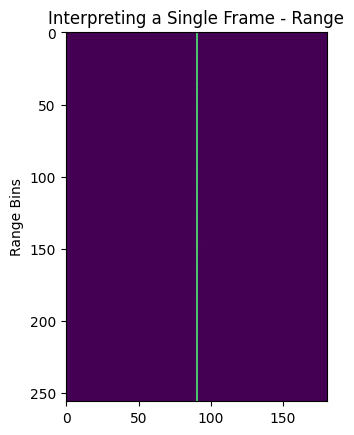

In [ ]:
# plt.imshow(np.abs(np.fft.fftshift(np.fft.fft(mergedRadarDepthRgb['heatmapResult'][0],axis=0))).T)
# plt.ylabel('Range Bins')
# plt.title('Interpreting a Single Frame - Range')
# plt.show()

Range Resolution: 0.033482142857142856 [meters/second]
Velocity Resolution: 0.054842656016247444 [meters/second]


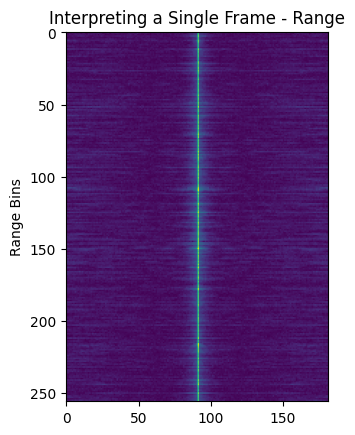

In [67]:
# plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft(mergedRadarDepthRgb['dopplerResult'][0],axis=0))).T))
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft(mergedRadarDepthRgb['dopplerResult'][0],axis=0))).T)
plt.ylabel('Range Bins')
plt.title('Interpreting a Single Frame - Range')
plt.show()

In [71]:

# Data sampling configuration
c = 3e8 # Speed of light (m/s)
sample_rate = 4400 # Rate at which the radar samples from ADC (ksps - kilosamples per second)
freq_slope = 77 # Frequency slope of the chirp (MHz/us)
adc_samples = 256 # Number of samples from a single chirp

start_freq = 77.4201 # Starting frequency of the chirp (GHz)
idle_time = 30 # Time before starting next chirp (us)
ramp_end_time = 62 # Time after sending each chirp (us)
num_chirps = 182 # Number of chirps per frame
num_tx = 3 # Number of transmitters

# Range resolution
range_res = (c * sample_rate * 1e3) / (2 * freq_slope * 1e12 * adc_samples)
print(f'Range Resolution: {range_res} [meters/second]')

# Apply the range resolution factor to the range indices
ranges = np.arange(adc_samples) * range_res
# Make sure your equation translates to the following
velocity_res = c / (2 * start_freq * 1e9 * (idle_time + ramp_end_time) * 1e-6 * num_chirps * num_tx)
print(f'Velocity Resolution: {velocity_res} [meters/second]')

# Apply the velocity resolution factor to the doppler indicies
velocities = np.arange(num_chirps) - (num_chirps // 2)
velocities = velocities * velocity_res

Range Resolution: 0.033482142857142856 [meters/second]
Velocity Resolution: 0.038570659176261936 [meters/second]


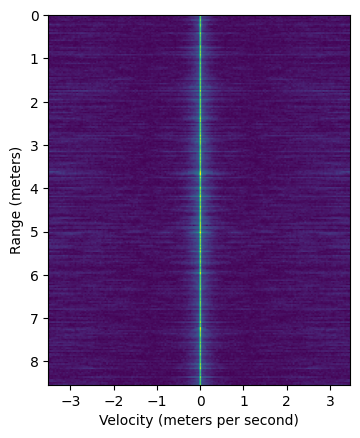

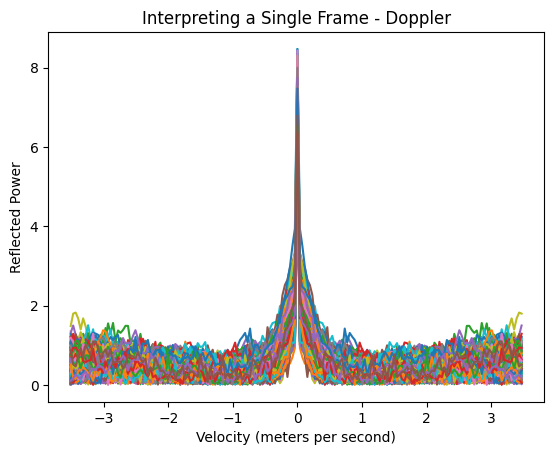

In [72]:
powers = np.abs(np.fft.fftshift(np.fft.fft(mergedRadarDepthRgb['dopplerResult'][0],axis=0)))

# Plot with units
plt.imshow(powers.T, extent=[velocities.min(), velocities.max(), ranges.max(), ranges.min()])
plt.xlabel('Velocity (meters per second)')
plt.ylabel('Range (meters)')
plt.show()

plt.plot(velocities, powers)
plt.xlabel('Velocity (meters per second)')
plt.ylabel('Reflected Power')
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

In [66]:
# plt.imshow(np.abs(np.fft.fftshift(np.fft.fft(mergedRadarDepthRgb['dopplerResult'][0],axis=0))))
# plt.ylabel('Range Bins')
# plt.title('Interpreting a Single Frame - Range')
# plt.show()

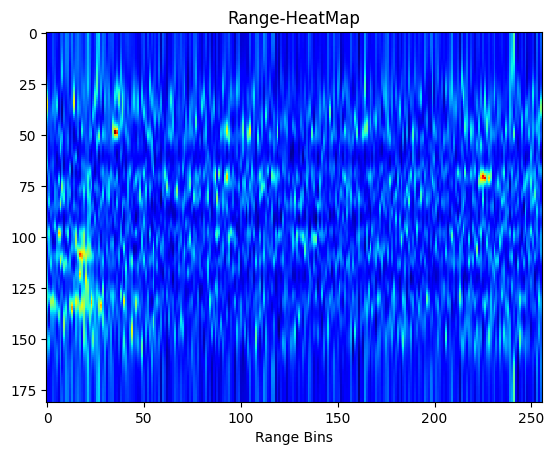

In [ ]:
mergedRadarDepthRgb['rangeAzimuthzResult'][0][]



[array([0.60144221, 0.60144221, 1.50360553, 1.54656569, 4.51081659,
        1.50360553, 1.54656569, 3.99529469, 4.51081659, 1.50360553,
        1.54656569, 1.50360553, 1.54656569, 9.66603554, 3.99529469,
        9.62307538, 9.66603554, 9.7089957 , 3.99529469, 9.62307538,
        9.66603554, 9.7089957 , 9.79491602, 9.62307538, 9.66603554,
        9.7089957 , 9.79491602, 0.25776095, 0.73032269, 0.77328284,
        0.816243  , 0.73032269, 0.77328284, 0.816243  , 0.73032269,
        0.77328284, 0.73032269, 0.77328284, 0.73032269, 0.73032269,
        0.85920316, 0.85920316, 0.98808363, 0.98808363, 0.55848205,
        0.55848205, 1.89024695, 1.89024695]),
 array([0.01745329, 0.03490659, 0.26179939, 0.26179939, 0.26179939,
        0.27925268, 0.27925268, 0.27925268, 0.27925268, 0.29670597,
        0.29670597, 0.31415927, 0.31415927, 0.64577182, 0.66322512,
        0.66322512, 0.66322512, 0.66322512, 0.68067841, 0.68067841,
        0.68067841, 0.68067841, 0.68067841, 0.6981317 , 0.6981317 ,
  

In [ ]:
doppler_heatmaps = np.array(mergedRadarDepthRgb['dopplerResult'].values.tolist())

In [34]:
mergedRadarDepthRgb['rangeResult'][0].sum(axis=(0,1)).shape

(256,)

In [26]:
folder_path = processedDataFolder_name + "visualization/prestudy"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")

Folder './processedData/2025-03-12_11-54-18/visualization/prestudy' created.


In [28]:
for frameIDX, row in tqdm(mergedRadarDepthRgb.iterrows(), total=len(mergedRadarDepthRgb), desc="Processing frames"):
    fig = plt.figure(figsize=(20, 14))
    fig.suptitle(f"Point Cloud Visualizations", fontsize=7, fontweight='bold')  # Main title

    ax1 = fig.add_subplot(241, projection='3d')
    scatter1 = ax1.scatter(mergedRadarDepthRgb["radarPCD"][frameIDX][:, 0], mergedRadarDepthRgb["radarPCD"][frameIDX][:, 1], mergedRadarDepthRgb["radarPCD"][frameIDX][:, 2],c=mergedRadarDepthRgb['power'][frameIDX], cmap='viridis', s=1)
    ax1.set_title("Input Point Cloud")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    ax2 = fig.add_subplot(242, projection='3d')
    scatter2 = ax2.scatter(mergedRadarDepthRgb["depthPCD"][frameIDX][:, 0], mergedRadarDepthRgb["depthPCD"][frameIDX][:, 1], mergedRadarDepthRgb["depthPCD"][frameIDX][:, 2], 
                        c=mergedRadarDepthRgb["depthPCD"][frameIDX][:, 2], cmap='viridis', s=1)
    ax2.set_title("Ground Truth Point Cloud")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    ax3 = fig.add_subplot(243)


    # timestampStr = mergedRadarDepthRgb['datetime'].split(" ")[-1]
    rgbFilePt = mergedRadarDepthRgb['rgbFilepath'][frameIDX]
    # print(rgbFilePt)
    img = Image.open(rgbFilePt)

    ax3.imshow(img)  
    ax3.set_title("RGB Image")
    ax3.axis("off")

    ax4 = fig.add_subplot(244)
    ax4.imshow(mergedRadarDepthRgb['dopplerResult'][frameIDX], aspect='auto', cmap='jet', interpolation='nearest')
    # ax4.c(label="Doppler Value")
    ax4.set_xlabel("Doppler Bins")
    ax4.set_ylabel("Range Bins")
    ax4.set_title("Doppler Map")

    ax5 = fig.add_subplot(245)
    ax5.plot(np.abs(mergedRadarDepthRgb['rangeResult'][frameIDX].sum(axis=(0,1))))
    ax5.set_xlabel("Range Bins")
    ax5.set_ylabel("Time Frames")
    ax5.set_title("Range Heatmap")

    ax6 = fig.add_subplot(246)
    ax6.imshow(mergedRadarDepthRgb['heatmapResult'][frameIDX], aspect='auto', cmap='jet', interpolation='nearest')
    # ax4.c(label="Doppler Value")
    ax6.set_xlabel("")
    ax6.set_ylabel("")
    ax6.set_title("Raw Heatmap")

    

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.savefig(f"{folder_path}/{frameIDX}.png", dpi=300, bbox_inches='tight')
    # plt.show()
    
    plt.close(fig)


Processing frames:   0%|          | 0/144 [00:00<?, ?it/s]

./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_46_783143.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_47_015956.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_47_207420.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_47_394090.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_47_582974.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_47_815953.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_48_018103.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_48_198463.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_48_410860.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_48_612145.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_48_784295.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_48_992008.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-29_12_41_49_108362.jpg
./datasets/image_data/2025-01-29_12_41_45/2025-01-2

In [ ]:
startProcessingForNewData = True
randomDownSample = False
doDownSampling = True
visulization = False
target_num_points = 3072

In [ ]:
print("Importing Saved Data")
# pointcloudRadarDepth = pd.read_pickle("./mergedRadarDepth.pkl")
pointcloudRadarDepth = mergerdPcdDepth
pointcloudRadarDepth.reset_index(drop=True, inplace=True)

In [ ]:
if doDownSampling:

    pointcloudRadarDepth["sampleDepth"] = None
    if randomDownSample:
        downsample_size = 2000  # Specify the desired downsampled size
        # downsampled_pcd = np.empty((pointcloudRadarDepth.shape[0], downsample_size, 3))
        for index,row in pointcloudRadarDepth.iterrows():
            # print(index)
            indices = np.random.choice(307200, downsample_size, replace=False)  # Random indices
            # pointcloudRadarDepth.loc[index, "sampleDepth"] = pointcloudRadarDepth["depthPCD"].iloc[index][indices].tolist()  # Select points using the random indices
            pointcloudRadarDepth.at[index, "sampleDepth"] = pointcloudRadarDepth["depthPCD"].iloc[index][indices]
    else:
        downsampled_frames = []
        for index,row in pointcloudRadarDepth.iterrows():
            pcd = o3d.geometry.PointCloud()
            print(index)
            voxel_size = 0.05  # Adjust voxel size for desired resolution
            pcd.points = o3d.utility.Vector3dVector(pointcloudRadarDepth["depthPCD"][index])
            #density based downsampling
            

            downsampled_pcd = density_based_downsampling(pcd, target_num_points,voxelSize=0.05)
            downsampled_points = np.asarray(downsampled_pcd.points)
            print("downsampled_points.shape",downsampled_points.shape)
            pointcloudRadarDepth.at[index, "sampleDepth"] = downsampled_points
    pointcloudRadarDepth.to_pickle(processedDataFolder_name + "pointcloudRadarDepth.pkl")
    print("Down Samling Done, pointcloudRadarDepth.pkl Exported")
else:
    pointcloudRadarDepth = pd.read_pickle(processedDataFolder_name + "pointcloudRadarDepth.pkl")
    print("Existing Down Sampled file imported")

In [ ]:
pkl_file = processedDataFolder_name + "mergedRadarDepth.pkl" 

outputDirTrain = processedDataFolder_name + "droneData_Train/processedData/"  
outputDirTest = processedDataFolder_name + "droneData_Test/processedData/"  

txt_file_train = processedDataFolder_name + "droneData_Train/datalist.txt" 
txt_file_test = processedDataFolder_name + "droneData_Test/datalist.txt" 

os.makedirs(outputDirTrain, exist_ok=True)
os.makedirs(outputDirTest, exist_ok=True)

df = pd.read_pickle(pkl_file)
df.reset_index(drop=True, inplace=True)

if not all(col in df.columns for col in ['radarPCD', 'depthPCD', 'datetime']):
    raise ValueError("PKL file must contain 'radarPCD', 'depthPCD', and 'datetime' columns.")


# Split data into train (80%) and test (20%)
train_size = int(0.8 * len(df)) 
indices = np.arange(len(df))
np.random.shuffle(indices)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

with open(txt_file_train, "w") as train_out, open(txt_file_test, "w") as test_out:
    for idx in tqdm(train_indices, desc="Saving Train Data", total=len(train_indices)):
        row = df.iloc[idx]
        mat_file_name = f"{idx + 1}_mmwave.mat"
        mat_file_path = os.path.join(outputDirTrain, mat_file_name)

        savemat(mat_file_path, {
            'radarPCD': row['radarPCD'],
            'depthPCD': row['depthPCD'],
            'datetime': row['datetime']
        })
        train_out.write(mat_file_path + "\n")

    for idx in tqdm(test_indices, desc="Saving Test Data", total=len(test_indices)):
        row = df.iloc[idx]
        mat_file_name = f"{idx + 1}_mmwave.mat"
        mat_file_path = os.path.join(outputDirTest, mat_file_name)

        savemat(mat_file_path, {
            'radarPCD': row['radarPCD'],
            'depthPCD': row['depthPCD'],
            'datetime': row['datetime']
        })
        test_out.write(mat_file_path + "\n")

print(f"Exported {len(train_indices)} train .mat files to '{outputDirTrain}' and recorded in '{txt_file_train}'.")
print(f"Exported {len(test_indices)} test .mat files to '{outputDirTest}' and recorded in '{txt_file_test}'.")


In [ ]:
processedDataFolder_name

In [1]:
from PIL import Image
import os

image_folder = "./processedData/2025-03-12_11-54-18/visualization/prestudy"
output_gif = "./processedData/2025-03-12_11-54-18/visualization/HeatmapDoppler.gif"

image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

images = [Image.open(os.path.join(image_folder, img)) for img in image_files]
images = images[-46:]
# Save as GIF
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],  
    duration=.001,  # Duration per frame in milliseconds (adjust as needed)
    loop=0  
)

print(f"GIF saved as {output_gif}")


GIF saved as ./processedData/2025-03-12_11-54-18/visualization/HeatmapDoppler.gif
